In [9]:
import numpy as np
import tensorflow as tf
import gym
import random
import matplotlib.pyplot as plt

In [2]:
env = gym.make('FrozenLake-v0')

## Tutorial
This section's code is from the fantastic [Arthur Julianji](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0).

In [4]:
#Initialize table with all zeros
Q = np.zeros([env.observation_space.n,env.action_space.n])
# Set learning parameters
lr = .8
y = .95
num_episodes = 2000
#create lists to contain total rewards and steps per episode
#jList = []
rList = []
for i in range(num_episodes):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    #The Q-Table learning algorithm
    while j < 99:
        j+=1
        #Choose an action by greedily (with noise) picking from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        #Get new state and reward from environment
        s1,r,d,_ = env.step(a)
        #Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
    #jList.append(j)
    rList.append(rAll)

In [7]:
print("Score over time: " +  str(sum(rList)/num_episodes))

Score over time: 0.6695


In [8]:
print("Final Q-Table Values")
print(Q)

Final Q-Table Values
[[  3.10856132e-01   2.29110970e-02   1.19062571e-02   2.27125644e-02]
 [  1.63244122e-03   9.54958061e-04   1.81886632e-03   2.38015889e-01]
 [  3.08354457e-03   2.81884842e-03   4.49526113e-03   2.38382917e-01]
 [  3.38239749e-04   2.37475115e-03   1.03423298e-03   8.40360961e-02]
 [  4.04468244e-01   3.03583326e-03   4.72231739e-03   4.65804064e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.51309583e-01   2.25699729e-04   5.19159948e-04   1.06520170e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.10934083e-03   1.56970942e-03   6.96314845e-04   5.39634811e-01]
 [  6.41125908e-03   5.96182679e-01   0.00000000e+00   7.39328000e-04]
 [  2.20202207e-01   7.81426126e-04   1.16114113e-03   2.84271796e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.18407621e-03   0.00000000e+00   7.82147052e-01   2

In [10]:
tf.reset_default_graph()

#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [14]:
%%time

init = tf.global_variables_initializer()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.4445%


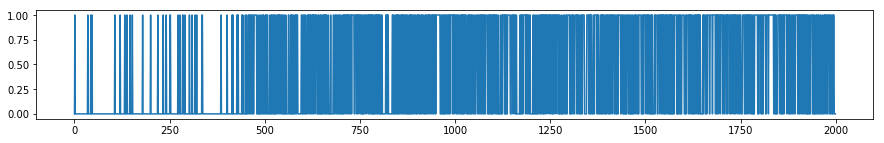

In [17]:
plt.figure(figsize=(15,2))
plt.plot(rList)
plt.show()

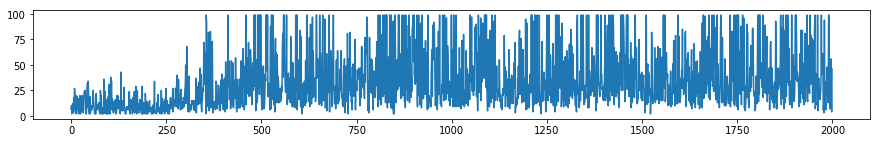

In [18]:
plt.figure(figsize=(15,2))
plt.plot(jList)
plt.show()

## 8x8 Frozen Lake

This section is the same thing with a one layer NN and a Q learning algo, but on the 8x8 Frozen Lake game.

In [19]:
env = gym.make('FrozenLake8x8-v0')

In [21]:
tf.reset_default_graph()

# NN
inputs1 = tf.placeholder(shape=[1,64],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([64,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

# loss and training ops
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [26]:
%%time

# initialize
init = tf.global_variables_initializer()

# hyperparameters
y = .99
e = 0.1
num_episodes = 20000

jList = []
rList = []

# run it
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        s = env.reset()
        rAll = 0
        d = False
        j = 0

        while j < 99:
            j+=1
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(64)[s:s+1]})
            
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()

            s1,r,d,_ = env.step(a[0])
            
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(64)[s1:s1+1]})
            
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(64)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            
            if d == True:
                e = 1./((i/50) + 10)
                break
                
        jList.append(j)
        rList.append(rAll)
        
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.4193%
CPU times: user 14min 38s, sys: 47.2 s, total: 15min 25s
Wall time: 11min 1s


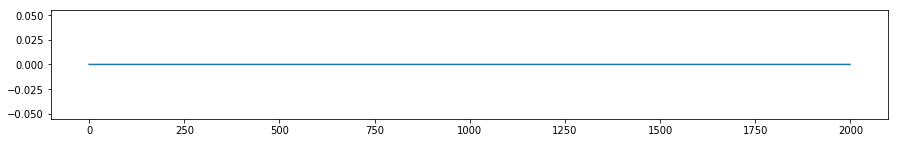

In [24]:
plt.figure(figsize=(15,2))
plt.plot(rList)
plt.show()

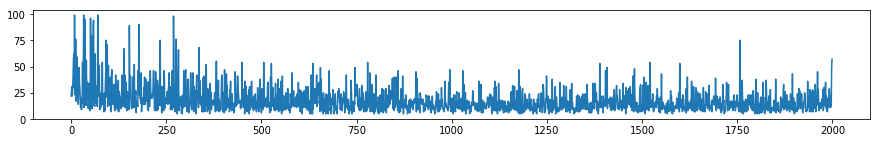

In [25]:
plt.figure(figsize=(15,2))
plt.plot(jList)
plt.show()